In [1]:
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Cropping2D

from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from keras.layers import Dense, Activation, Flatten, Dropout, Lambda

Using TensorFlow backend.


                                   center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   
1   IMG/left_2016_12_01_13_30_48_404.jpg   
2   IMG/left_2016_12_01_13_31_12_937.jpg   
3   IMG/left_2016_12_01_13_31_13_037.jpg   
4   IMG/left_2016_12_01_13_31_13_177.jpg   

                                    right  steering  throttle  brake  \
0   IMG/right_2016_12_01_13_30_48_287.jpg         0         0      0   
1   IMG/right_2016_12_01_13_30_48_404.jpg         0         0      0   
2   IMG/right_2016_12_01_13_31_12_937.jpg         0         0      0   
3   IMG/right_2016_12_01_13_31_13_037.jpg         0         0      0   
4   IMG/right_2016_12_01_13_31_13_177.jpg         0         0      0   

       speed  
0  22.148290  
1

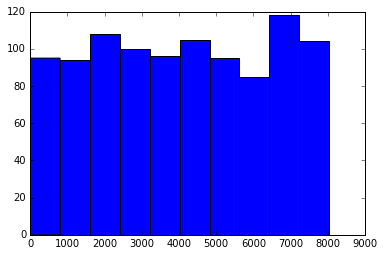

In [14]:
#Pandas Testing
import pandas as pd

DF = pd.read_csv('data/driving_log.csv')
print(DF.head())
test = DF.loc[DF['steering']==0]

row = np.random.choice(test.index)
print(row)
print(test.loc[row])
print("Center Image:")
print(test.loc[row]['center'])


plt.hist(np.random.randint(len(DF),size=1000))
plt.show()

In [3]:
def getImage(source_path):
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/' + filename
    return cv2.imread(current_path)

steering_correction = 0.25

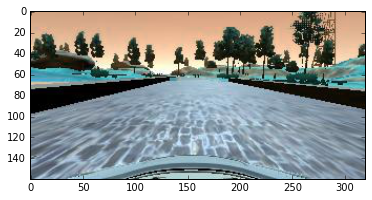

24108


In [4]:
#compiling data set without generator
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#print(lines[0])
lines=lines[1:]
#print(lines[0])
images = []
measurements = []

for line in lines:
    
    center_image = getImage(line[0])
    left_image = getImage(line[1])
    right_image = getImage(line[2])
    
    steering_center = float(line[3])
    steering_left = (steering_center + steering_correction)
    steering_right = (steering_center - steering_correction)
    
    images.append(center_image)
    images.append(left_image)
    images.append(right_image)
    
    measurements.append(steering_center)
    measurements.append(steering_left)
    measurements.append(steering_right)
    
    if(steering_center != 0.2 and steering_center != 0 and steering_center != -0.2 and False):
        flipped_center_im = np.fliplr(center_image)
        flipped_left_im = np.fliplr(left_image)
        flipped_right_im = np.fliplr(right_image)

        images.append(flipped_center_im)
        images.append(flipped_left_im)
        images.append(flipped_right_im)

        flipped_steer_center = -steering_center
        flipped_steer_left = -steering_center + steering_correction
        flipped_steer_right = -steering_right - steering_correction

        measurements.append(flipped_steer_center)
        measurements.append(flipped_steer_left)
        measurements.append(flipped_steer_right)

X_train = np.array(images)
y_train = np.array(measurements)

plt.imshow(X_train[0])
plt.show()

print(len(X_train))

Number of images:  24108


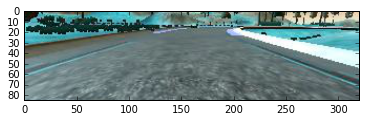

[-0.25  0.    0.25]


In [36]:
#View Data
print("Number of images: ",len(X_train))
image = X_train[5000]
TestImage = image/255
(y,x,z) = TestImage.shape

TestImage = TestImage[50:y-25,0:x]
#Check Preprocessing
plt.imshow(TestImage)
plt.show()

#plt.hist(y_train,bins=5000)

(values,counts)=np.unique(y_train, return_counts=True)
ind=counts.argsort()[-3:]

print(values[ind])

In [37]:
#Generator to get Random Gauissian Distribution of steering angles
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

DF = pd.read_csv('data/driving_log.csv')   

MaxSteer = DF['steering'].max()
MinSteer = DF['steering'].min()

print(MaxSteer, MinSteer)
test=np.random.normal(0,0.25,len(DF))
print(np.max(test),np.min(test))
print(np.random.normal(0,0.2))

def generator(samples, batch_size=32, SD=0.3):
    num_samples = int(len(samples)/2)
    while 1:
        #This gives us the number of times we need to shuffle from the samples
        samples = samples.sort_values(by=['steering'])
        DF = samples.copy()
        for offset in range(0, num_samples, batch_size):
            steerAngles = np.random.randint(len(DF), size = batch_size)
            images = []
            angles = []
            
            for row in steerAngles:
                center_image = getImage(DF.loc[row]['center'])
                left_image = getImage(DF.loc[row]['left'])
                right_image = getImage(DF.loc[row]['right'])

                steering_center = float(DF.loc[row]['steering'])
                steering_left = (steering_center + steering_correction)
                steering_right = (steering_center - steering_correction)
                
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)

                angles.append(steering_center)
                angles.append(steering_left)
                angles.append(steering_right)
                
                flipped_center_image=np.fliplr(center_image)
                flipped_left_image=np.fliplr(left_image)
                flipped_right_image=np.fliplr(right_image)
                                
                flipped_steering_center = -steering_center
                flipped_steering_left = flipped_steering_center + steering_correction
                flipped_steering_right = flipped_steering_center - steering_correction
                
                images.append(flipped_center_image)
                images.append(flipped_left_image)
                images.append(flipped_right_image)
                
                angles.append(flipped_steering_center)
                angles.append(flipped_steering_left)
                angles.append(flipped_steering_right)
                
                DF=DF.drop(row)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)
        
train_samples, validation_samples = train_test_split(DF, test_size=0.2, shuffle = True)
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

x_train_gen, y_train_gen = (next(train_generator))
x_valid_gen, y_valid_gen = (next(validation_generator))

print("Number of train_samples = ", len(train_samples), "Number of Validation = ", len(validation_samples))

plt.imshow(x_train_gen[0])
plt.show()

plt.hist(y_train_gen)
plt.show()

plt.hist(y_valid_gen)
plt.show()

1.0 -0.9426954
0.999688176631684 -0.9417612841815345
-0.19486499285547546


KeyError: 'the label [1170] is not in the [index]'

1.0 -0.9426954
0.9021306617468063 -0.9872496230712218
0.07587117071622146
Number of train_samples =  6428 Number of Validation =  1608


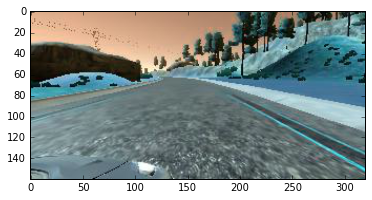

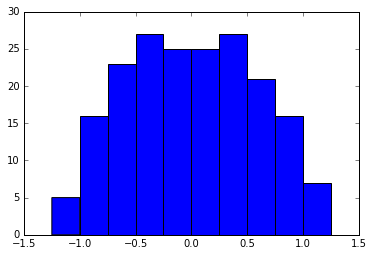

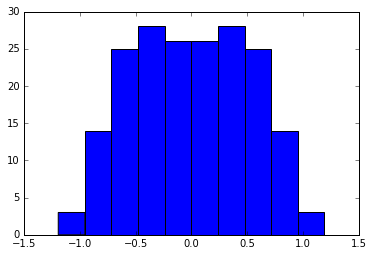

In [42]:
#Generator to get Random Gauissian Distribution of steering angles
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

DF = pd.read_csv('data/driving_log.csv')   

MaxSteer = DF['steering'].max()
MinSteer = DF['steering'].min()

print(MaxSteer, MinSteer)
test=np.random.normal(0,0.25,len(DF))
print(np.max(test),np.min(test))
print(np.random.normal(0,0.2))

def generator(samples, batch_size=32, BUFFER=0.005):
    num_samples = int(len(samples)/2)
    while 1:
        #This gives us the number of times we need to shuffle from the samples
        samples = samples.sample(frac=1).reset_index(drop=True)
        DF = samples.copy()
        savedBuffer = BUFFER
        for offset in range(0, num_samples, batch_size):
            steerAngles = np.random.uniform(MinSteer+BUFFER*2,MaxSteer-BUFFER*2, batch_size)
            images = []
            angles = []
            
            for steerAngle in steerAngles:
                BUFFER=savedBuffer
                anglesDF = DF.loc[(DF['steering']<= (steerAngle + BUFFER)) & (DF['steering'] >= (steerAngle - BUFFER))]
                while(anglesDF.empty):
                    #print("Buffer Empty", len(DF))
                    BUFFER+=savedBuffer
                    anglesDF = DF.loc[(DF['steering']<= (steerAngle + BUFFER)) & (DF['steering'] >= (steerAngle - BUFFER))]
                row = np.random.choice(anglesDF.index)
                center_image = getImage(anglesDF.loc[row]['center'])
                left_image = getImage(anglesDF.loc[row]['left'])
                right_image = getImage(anglesDF.loc[row]['right'])

                steering_center = float(anglesDF.loc[row]['steering'])
                steering_left = (steering_center + steering_correction)
                steering_right = (steering_center - steering_correction)
                
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)

                angles.append(steering_center)
                angles.append(steering_left)
                angles.append(steering_right)
                
                flipped_center_image=np.fliplr(center_image)
                flipped_left_image=np.fliplr(left_image)
                flipped_right_image=np.fliplr(right_image)
                                
                flipped_steering_center = -steering_center
                flipped_steering_left = flipped_steering_center + steering_correction
                flipped_steering_right = flipped_steering_center - steering_correction
                
                images.append(flipped_center_image)
                images.append(flipped_left_image)
                images.append(flipped_right_image)
                
                angles.append(flipped_steering_center)
                angles.append(flipped_steering_left)
                angles.append(flipped_steering_right)
                
                DF=DF.drop(row)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)
        
train_samples, validation_samples = train_test_split(DF, test_size=0.2, shuffle = True)
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

x_train_gen, y_train_gen = (next(train_generator))
x_valid_gen, y_valid_gen = (next(validation_generator))

print("Number of train_samples = ", len(train_samples), "Number of Validation = ", len(validation_samples))

plt.imshow(x_train_gen[0])
plt.show()

plt.hist(y_train_gen)
plt.show()

plt.hist(y_valid_gen)
plt.show()

Number of train_samples =  6428 Number of Validation =  1608


(array([ 7., 10., 93., 28., 96., 30., 94., 18.,  4.,  4.]),
 array([-0.6610484 , -0.52357974, -0.38611108, -0.24864242, -0.11117376,
         0.0262949 ,  0.16376356,  0.30123222,  0.43870088,  0.57616954,
         0.7136382 ]),
 <a list of 10 Patch objects>)

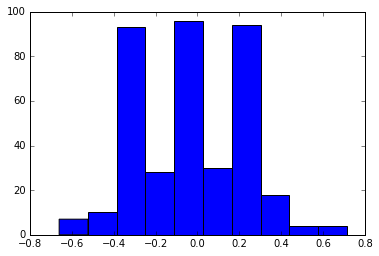

In [8]:
#Generator just taking random samples from data set
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                center_image = getImage(batch_sample[0])
                left_image = getImage(batch_sample[1])
                right_image = getImage(batch_sample[2])

                steering_center = float(batch_sample[3])
                steering_left = (steering_center + steering_correction)
                steering_right = (steering_center - steering_correction)
                
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)

                angles.append(steering_center)
                angles.append(steering_left)
                angles.append(steering_right)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

print("Number of train_samples = ", len(train_samples), "Number of Validation = ", len(validation_samples))
x_train_gen, y_train_gen = (next(train_generator))
plt.hist(y_train_gen)
plt.show()

In [43]:
input = Input(shape=(160, 320, 3))

preProcess1 = Lambda(lambda x: x/255.0 - 0.5)(input)
#preProcess1 = Lambda(lambda x: x/127.5 -1.)(input)

crop1 = Cropping2D(cropping=((50,25),(0,0)), input_shape = (3,160,320))(preProcess1)

conv1 = Convolution2D(64, (7, 7), strides=2)(crop1)
conv1 = MaxPooling2D(pool_size=(3,3), strides=2)(conv1)

conv2 = Convolution2D(192, (3, 3), strides=1)(conv1)
conv2 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv2)

#Activation Layer
conv2 = Activation('relu')(conv2)

#Incesption Layer
Inception1Conv1 = Convolution2D(64, (1, 1), padding='same', activation='relu')(conv2)
Inception1Conv2 = Convolution2D(128, (3, 3), padding='same', activation='relu')(conv2)
Inception1Conv3 = Convolution2D(32, (5, 5), padding='same', activation='relu')(conv2)
Inception1MP = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(conv2)

Inception1 = concatenate([Inception1Conv1, Inception1Conv2, Inception1Conv3, Inception1MP], axis=3)

drop1 = Dropout(0.4)(Inception1)
act1 = Activation('relu')(drop1)
Flat1=Flatten()(act1)
#FCL1 = Dense(1000, activation='relu')(Flat1)
FCL2 = Dense(100, activation='relu')(Flat1)

output=Dense(1)(FCL2)

model = Model(inputs = input, outputs = output)
model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train, validation_split = 0.2, shuffle=True, epochs = 5)
model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/3,
          validation_data=validation_generator, validation_steps=len(validation_samples)/3, epochs=2)

model.summary()

model.save('model.h5')


#So far seems like multiple layers past a single inception have not been any better

#Investigate what goes into the inception

#Seems like the inception with two dense layers, try to get smallest model with 0.009 test and 0.1 validation

#Try edge detecting and gray scalling model and having two networks that converge to 1

#Best is the fully connected layers, may want to try smaller inception with large fully connected layers

#Next tests:
    #make generator faster
    #Uniform Distribution
    #Smaller Batch Size
    #My own generated Data



Epoch 1/2
2143/2142 [==============================] - 701s 327ms/step - loss: 0.0971 - val_loss: 0.0255
Epoch 2/2
2143/2142 [==============================] - 626s 292ms/step - loss: 0.0222 - val_loss: 0.0204
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 160, 320, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 160, 320, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
cropping2d_3 (Cropping2D)       (None, 85, 320, 3)   0           lambda_3[0][0]                   
_________________________________________________________________________________________________